In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

In [2]:
elec_data = read_csv('electrolyser_8hour.csv')
elec_data

/home/eduard/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (74,89,90,91,92,93,94,95,96,97,98,99,100,102,103,104,105) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,timestamp,offset_from_now,heap_free,log_loss,ucm_loss,board_temperature,mcu_temperature,voltage_12,voltage_24,voltage_5,...,PSU_out_power,TSH106_in,TSLL102B_in,V101_out_open,V105_out_open,V106_out_open,WPS104_in,PSH102_in,PSHH101B_in,DRYCONTACT_in
0,2021-06-01 02:15:00 +0000,-38.0,37160.0,155.0,0.0,33.830,41.818,11.865,23.302,4.961,...,False,False,False,True,False,NaN,False,False,False,False
1,2021-06-01 02:15:02 +0000,-38.0,37160.0,155.0,0.0,33.823,41.818,11.865,23.306,4.961,...,False,False,False,True,False,NaN,False,False,False,False
2,2021-06-01 02:15:03 +0000,-39.0,37160.0,155.0,0.0,33.830,41.822,11.865,23.304,4.961,...,False,False,False,True,False,NaN,False,False,False,False
3,2021-06-01 02:15:04 +0000,-38.0,37160.0,155.0,0.0,33.832,41.793,11.866,23.307,4.960,...,False,False,False,True,False,NaN,False,False,False,False
4,2021-06-01 02:15:05 +0000,-39.0,37160.0,155.0,0.0,33.825,41.807,11.866,23.305,4.961,...,False,False,False,True,False,NaN,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25052,2021-06-01 10:15:55 +0000,-41.0,37160.0,155.0,0.0,45.726,53.899,11.862,23.323,4.956,...,False,False,False,True,False,NaN,False,False,False,False
25053,2021-06-01 10:15:56 +0000,-40.0,37160.0,155.0,0.0,45.728,53.872,11.862,23.319,4.957,...,False,False,False,True,False,NaN,False,False,False,False
25054,2021-06-01 10:15:58 +0000,-42.0,37160.0,155.0,0.0,45.762,53.891,11.861,23.321,4.956,...,False,False,False,True,False,NaN,False,False,False,False
25055,2021-06-01 10:15:59 +0000,-41.0,37160.0,155.0,0.0,45.709,53.888,11.861,23.321,4.956,...,False,False,False,True,False,NaN,False,False,False,False


In [3]:
Current_values = elec_data['HASS_in_a'].to_numpy()
T_values = elec_data['TT102A_in_c'].to_numpy()
PR_values = elec_data['production_rate'].to_numpy()
State_values = elec_data['state'].to_numpy()
H2_values1 = elec_data['h2_total'].to_numpy()
H2_values2 = elec_data['h2_flow'].to_numpy()

In [4]:
for i in range(len(PR_values)):
    if State_values[i] == 'idle' or State_values[i] == 'rampdown1' or State_values[i] == 'rampdown2':
        PR_values[i] = 0.0
    if PR_values[i] != 0 and (PR_values[i] < 60 or PR_values[i] > 100):
        PR_values[i] = PR_values[i-1]

    if np.isnan(PR_values[i]) or not np.isfinite(PR_values[i]):
        PR_values[i] = PR_values[i-1]

    if np.isnan(H2_values2[i]) or not np.isfinite(H2_values2[i]):
        H2_values2[i] = H2_values2[i-1]

    if np.isnan(Current_values[i]) or not np.isfinite(Current_values[i]):
        Current_values[i] = Current_values[i-1]

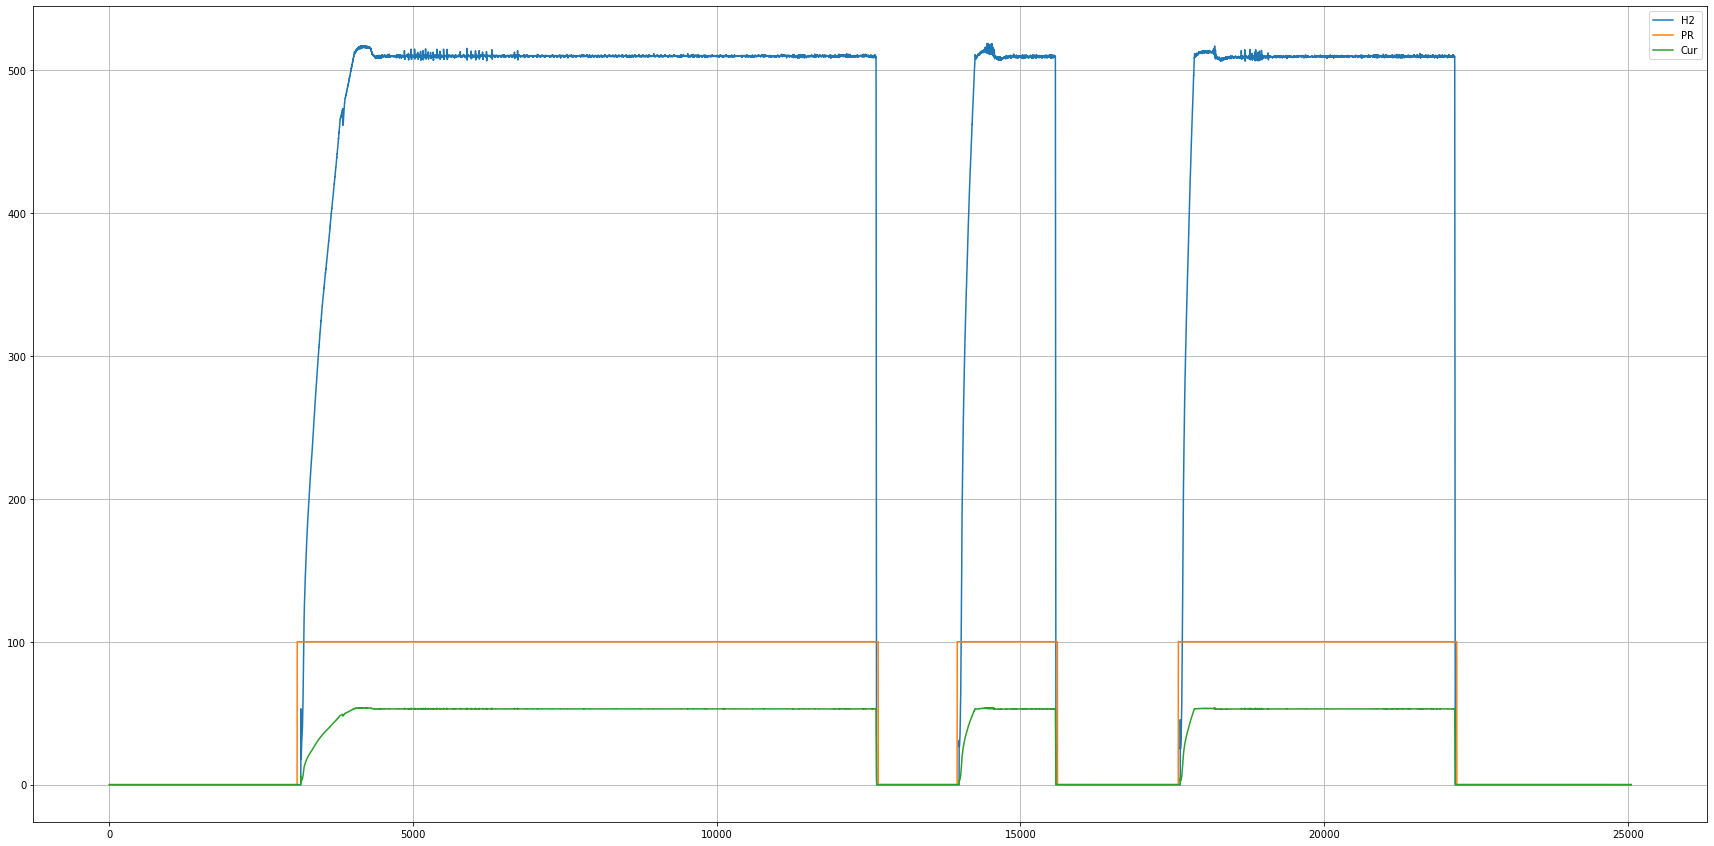

In [5]:
plt.figure(figsize=(30, 15))
plt.plot(H2_values2, label='H2')
plt.plot(PR_values, label='PR')
plt.plot(Current_values, label='Cur')
plt.legend()
plt.grid(visible=True)
plt.show()

In [6]:
H2_values2[10000]

509.721

In [7]:
I = Current_values / 53 # max(Current_values) = 53
I_ref = PR_values / 100 # max(PR) = 100
I_H = H2_values2 / 510

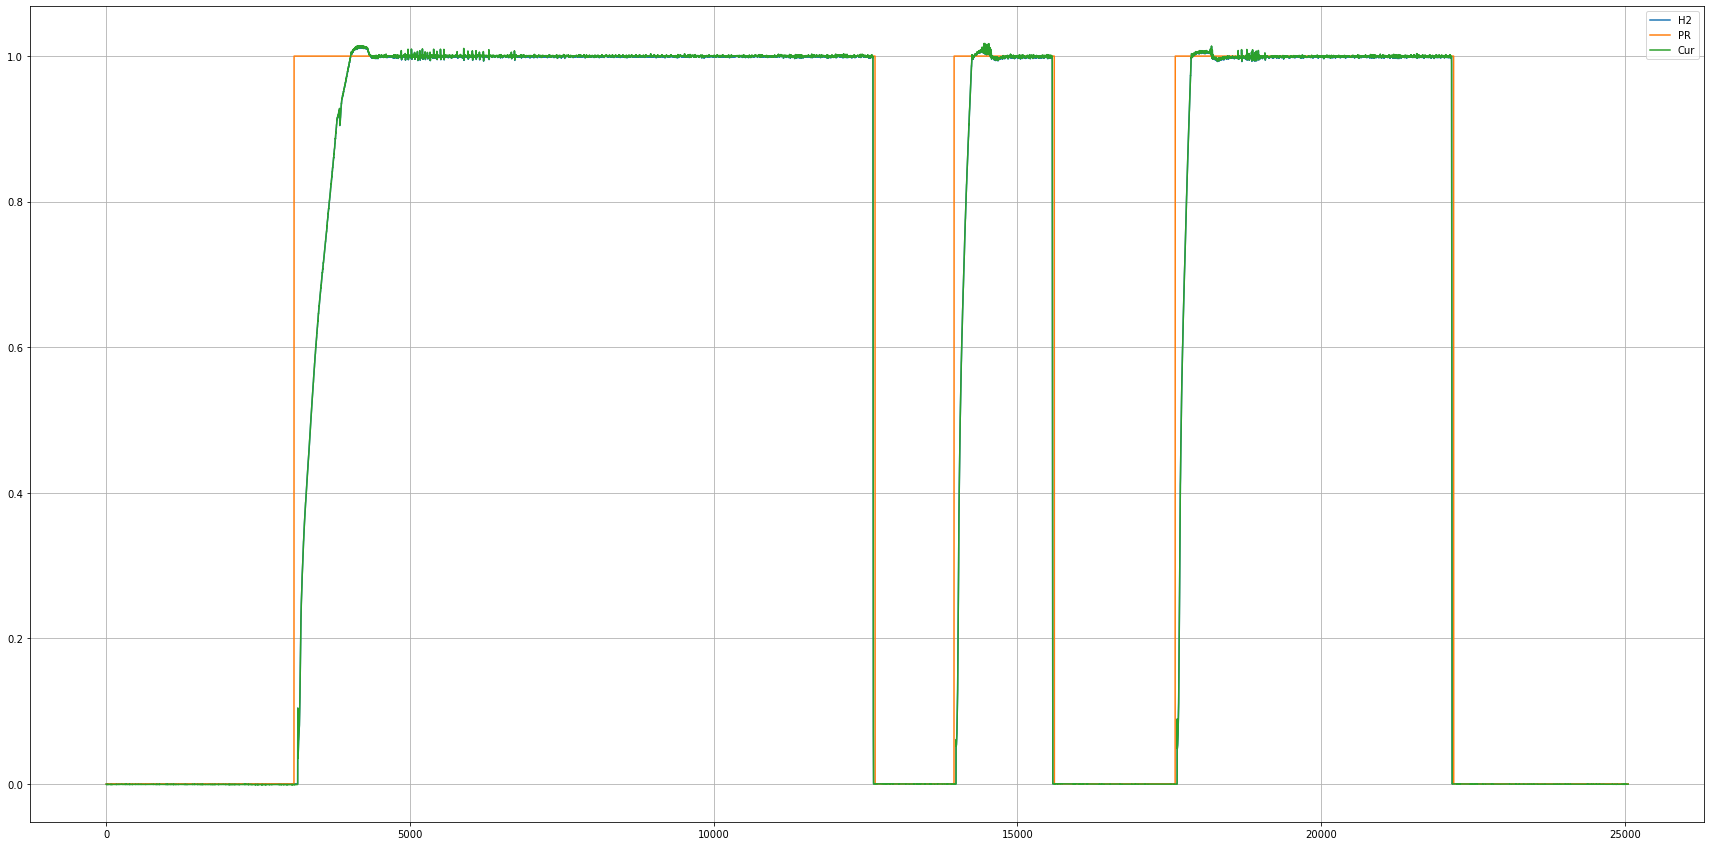

In [8]:
plt.figure(figsize=(30, 15))
plt.plot(I_H, label='H2')
plt.plot(I_ref, label='PR')
plt.plot(I, label='Cur')
plt.legend()
plt.grid(visible=True)
plt.show()

In [17]:
# I(k+2) = a_1 I(k+1) + a_0 I(k) + b_1 I_ref(k+1) + b_0 I_ref(k)

I_d = [I[0], I[1], I[2]]

general_coefs = [1.502179680711083, -0.5175998923844511, 0.08026058837803757, -0.06418856889652469]

ss_coefs = [1.1723810646442052, -0.2589601420866324, 0.2021464246772469/1.23, -0.09565027340865093/1.23]

rup_coefs = [1.4669415710603944, -0.478227825846913, -0.0005482814722645168/0.961959, 0.011409160041332633/0.961959]

state = "rump_up"

for k in range(3, len(I_ref)):

    values = [I_d[k-1], I_d[k-2], I_ref[k-1], I_ref[k-2]] # I_ref[k-1], I_ref[k-2], I_ref[k-3]

    if state == "steady":
        coefs = rup_coefs # ss_coefs

    elif state == "rump_up":
        coefs = rup_coefs

    else:
        print("wrong state")
        break

    i_d = np.dot(coefs, values)

    if state == "rump_up" and i_d >= 0.999:
        state = "steady"

    I_d.append( i_d )


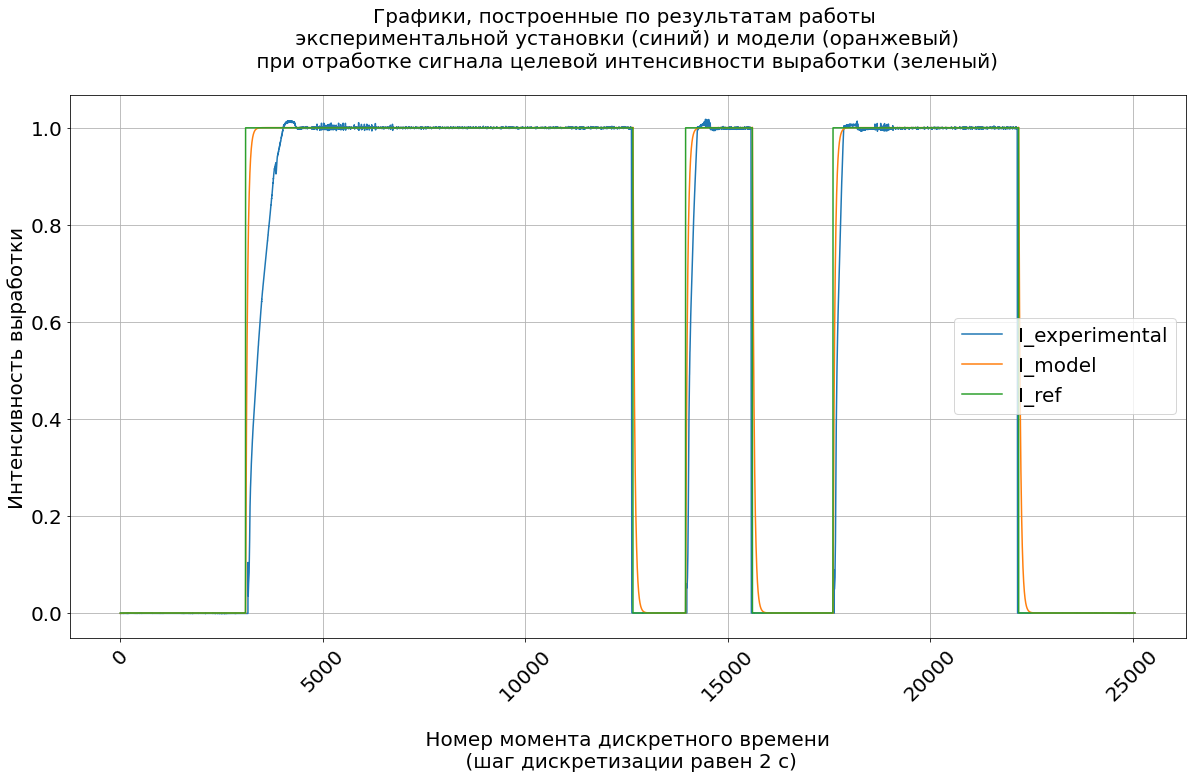

In [23]:

fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title("Графики, построенные по результатам работы \n экспериментальной установки (синий) и модели (оранжевый) \n при отработке сигнала целевой интенсивности выработки (зеленый) \n", fontsize=20)

# "Графики, построенные по результатам работы \n экспериментальной установки (синий) и модели (оранжевый) \n", fontsize=20
# "График сигнала целевой интенсивности выработки, \n подаваемого на экспериментальную установку и на вход модели \n", fontsize=20


plt.plot(I, label='I_experimental')
plt.plot((np.array(I_d)), label='I_model')
plt.plot(I_ref, label='I_ref')

ax.set_xlabel('\n Номер момента дискретного времени \n (шаг дискретизации равен 2 с)', fontsize=20)
ax.set_ylabel('Интенсивность выработки', fontsize=20)

plt.legend(prop={'size': 20})
plt.grid(visible=True)

#  Устанавливаем интервал основных делений:
# ax.xaxis.set_major_locator(ticker.MultipleLocator(15*60))
#  Устанавливаем интервал вспомогательных делений:
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

#  Тоже самое проделываем с делениями на оси "y":
# ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))

#  Настраиваем вид основных тиков:
ax.tick_params(axis = 'x', labelrotation = 45) # axis = 'both',
ax.tick_params(axis = 'both', labelsize = 20)

plt.show()


In [9]:
m1 = 0
m2 = 25000

In [10]:
I = I[m1:m2]
I_ref = I_ref[m1:m2]

In [11]:

# I(k+3) = a_2 I(k+2) + a_1 I(k+1) + a_0 I(k) + b_2 I_ref(k+2) + b_1 I_ref(k+1) + b_0 I_ref(k)
# I(k+2) = a_1 I(k+1) + a_0 I(k) + b_2 I_ref(k+2) + b_1 I_ref(k+1) + b_0 I_ref(k)

I_kp1 = I[1:]
I_kp1 = np.append(I_kp1, I_kp1[-1]+0.0001)

I_kp2 = I_kp1[1:]
I_kp2 = np.append(I_kp2, I_kp2[-1]+0.00009)

I_kp3 = I_kp2[1:]
I_kp3 = np.append(I_kp3, I_kp3[-1]+0.00007)

I_ref_kp1 = I_ref[1:]
I_ref_kp1 = np.append(I_ref_kp1, I_ref_kp1[-1])

I_ref_kp2 = I_ref_kp1[1:]
I_ref_kp2 = np.append(I_ref_kp2, I_ref_kp2[-1])

In [12]:
Y = copy.deepcopy(I_kp3)

m = m2 - m1

X = np.concatenate((I_kp2.reshape((1,m)),
                    I_kp1.reshape((1,m)),
                    I.reshape((1,m)),
                    I_ref_kp2.reshape((1,m)),
                    I_ref_kp1.reshape((1,m)),
                    I_ref.reshape((1,m))), axis=0).T

In [13]:
from sklearn import linear_model

In [14]:
reg = linear_model.LinearRegression()
reg.fit (X, Y)

LinearRegression()

In [15]:
[a2, a1, a0, b2, b1, b0] = reg.coef_

In [16]:
print( [a2, a1, a0, b2, b1, b0] )

[1.737430329854383, -0.6648755739875577, -0.07351624347546978, 0.0004028204678241387, 9.214042365973674e-05, 0.00042632188749325284]


# Modeling

In [17]:
# I(k+2) = a_1 I(k+1) + a_0 I(k) + b_1 I_ref(k+1) + b_0 I_ref(k)
# I(k+3) = a_2 I(k+2) + a_1 I(k+1) + a_0 I(k) + b_2 I_ref(k+2) + b_1 I_ref(k+1) + b_0 I_ref(k)

I_d = [I[0], I[1], I[2]]

ss_coefs = [1.2072953504102617, -0.3439831284856321, 0.03418207965588882, 0.21252082353000318, -0.1417672716069797, 0.05585099160045823]

ru_coefs = [1.485601599555871, -0.6488200691130582, 0.1487202012257744, -0.0010936066474041273, 0.00911970343470686, 0.006086297527376439]

general_coefs = [1.565109087528455, -0.6669487205319695, 0.08514182056698127, 0.07243594562330449, -0.06008670450216613, 0.0053254646257572535]

# ss_coefs_wout_norm = [1.207278249628781, -0.3439485777329985, 0.03416543830899797, 0.1126386919077291, -0.07513800831374536, 0.029600908408464105]

h8_coefs = [1.737430329854383, -0.6648755739875577, -0.07351624347546978, 0.0004028204678241387, 9.214042365973674e-05, 0.00042632188749325284]

for k in range(3, m):

    values = [I_d[k-1], I_d[k-2], I_d[k-3], I_ref[k-1], I_ref[k-2], I_ref[k-3]] # I_ref[k-1], I_ref[k-2], I_ref[k-3]

    coefs = h8_coefs

    i_d = np.dot(coefs, values)

    I_d.append( i_d )


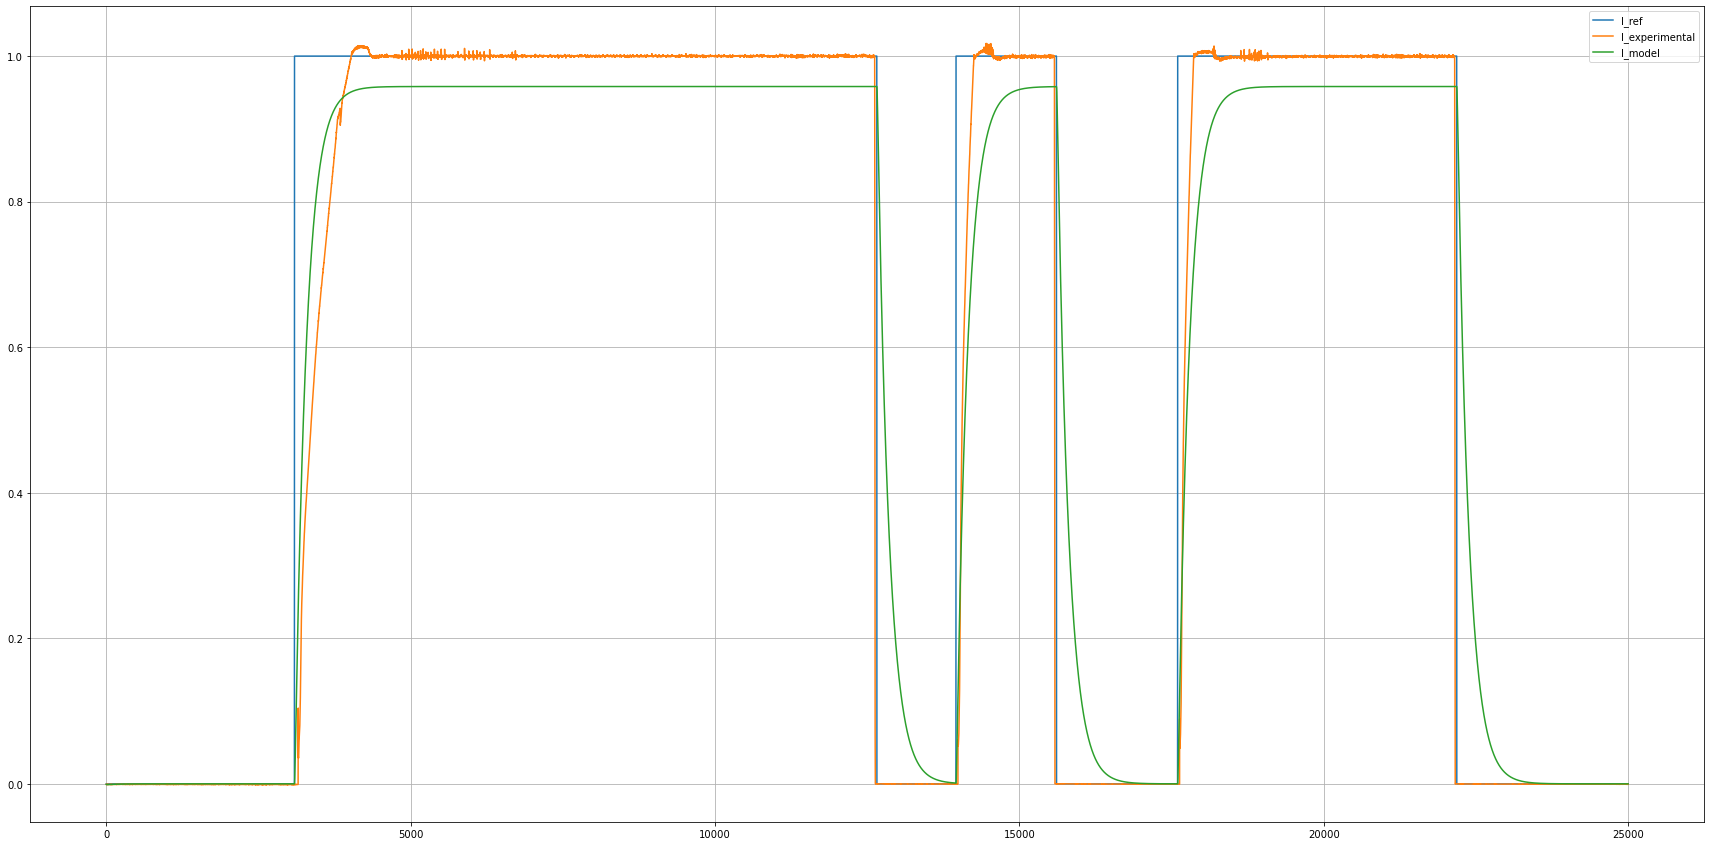

In [18]:

plt.figure(figsize=(30, 15))
plt.plot(I_ref, label='I_ref')
plt.plot(I, label='I_experimental')
plt.plot(I_d, label='I_model')

plt.legend()
plt.grid(visible=True)
plt.show()